# Getting Started with the AρρEEARS API: Submitting and Downloading a Point Request
### This tutorial demonstrates how to use Python to connect to the AρρEEARS API 
The Application for Extracting and Exploring Analysis Ready Samples ([AρρEEARS](https://appeears.earthdatacloud.nasa.gov/)) offers a simple and efficient way to access and transform geospatial data from a variety of federal data archives in an easy-to-use web application interface. AρρEEARS enables users to subset [geospatial data](https://appeears.earthdatacloud.nasa.gov/products) spatially, temporally, and by band/layer for point and area samples. AρρEEARS returns not only the requested data, but also the associated quality values, and offers interactive visualizations with summary statistics in the web interface.  The [AρρEEARS API](https://appeears.earthdatacloud.nasa.gov/api/) offers users **programmatic access** to all features available in AρρEEARS, with the exception of visualizations. The API features are demonstrated in this notebook.  
***
### Example: Submit a point request with multiple points in U.S. National Parks for extracting vegetation and land surface temperature data    
Connect to the AρρEEARS API, query the list of available products, submit a point sample request, download the request, become familiar with the AρρEEARS Quality API, and import the results into Python for visualization.  AρρEEARS point requests allow users to subset their desired data using latitude/longitude geographic coordinate pairs (points) for a time period of interest, and for specific data layers within data products. AρρEEARS returns the valid data from the parameters defined within the sample request.  

#### Data Used in the Example: 
- Data layers: 
    - Combined MODIS Leaf Area Index (LAI)  
        - [MCD15A3H.061](https://doi.org/10.5067/MODIS/MCD15A3H.061), 500m, 4 day: 'Lai_500m'      
    - Terra MODIS Land Surface Temperature    
        - [MOD11A2.061](https://doi.org/10.5067/MODIS/MOD11A2.061), 1000m, 8 day: 'LST_Day_1km', 'LST_Night_1km'       
***  
# Topics Covered:
1. **Getting Started**  
    1a. Set Up the Working Environment  
    1b. Login [Login]    
2. **Query Available Products [Products API]**  
    2a. Search and Explore Available Products [List Products]  
    2b. Search and Explore Available Layers [List Layers]      
3. **Submit a Point Request [Tasks]**  
    3a. Compile a JSON [Task Object]  
    3b. Submit a Task Request [Submit Task]  
    3c. Retrieve Task Status [Retrieve Task]  
4. **Download a Request [Bundle API]**    
    4a. Explore Files in Request Output [List Files]    
    4b. Download Files in a Request (Automation) [Download File]   
5. **Explore AρρEEARS Quality API [Quality API]**  
    5a. List Quality Layers [List Quality Layers]    
    5b. Show Quality Values [List Quality Values]   
    5c. Decode Quality Values [Decode Quality Values]   
6. **BONUS: Import Request Output and Visualize**    
    6a. Import CSV     
    6b. Plot Results (Line/Scatter Plots)  
***
### Dependencies:
- This tutorial was tested using Python 3.6.1.  
- A [NASA Earthdata Login](https://urs.earthdata.nasa.gov/) account is required to complete this tutorial. You can create an account at the link provided.    
***
### AρρEEARS Information:
To access AρρEEARS, visit: https://appeears.earthdatacloud.nasa.gov/ 
> For comprehensive documentation of the full functionality of the AρρEEARS API, please see the AρρEEARS [API Documentation](https://appeears.earthdatacloud.nasa.gov/api/).   
  
Throughout the tutorial, specific sections of the API documentation can be accessed by clicking on the bracketed [] links in the section headings. 

***
### Source Code used to Generate this Tutorial:
- [Jupyter Notebook](https://git.earthdata.nasa.gov/projects/LPDUR/repos/appeears-api-getting-started/browse/AppEEARS_API_Point.ipynb) 

***

# 1. Getting Started 

***
## 1a. Set Up the Working Environment
#### Import the required packages and set the input/working directory.

In [1]:
# Import packages
import requests as r
import getpass, pprint, time, os

#### If you are missing any of the packages above, download them in order to use the full functionality of this tutorial. 

In [2]:
# Set input directory, change working directory
inDir = 'H:/AppEEARS-Data-Resources/'           # IMPORTANT: Update to reflect directory on your OS
os.chdir(inDir)                                      # Change to working directory
api = 'https://appeears.earthdatacloud.nasa.gov/api/'  # Set the AρρEEARS API to a variable

<div class="alert alert-block alert-warning" >
<b>If you plan to execute this tutorial on your own OS, `inDir` above needs to be changed.</b>
</div> 

***
## 1b. Login [[Login](https://appeears.earthdatacloud.nasa.gov/api/#login)]
#### To submit a request, you must first login to the AρρEEARS API. Use the `getpass` package to enter your NASA Earthdata login **Username** and **Password**. When prompted after executing the code block below, enter your username followed by your password.

In [3]:
user = getpass.getpass(prompt = 'Enter NASA Earthdata Login Username: ')      # Input NASA Earthdata Login Username
password = getpass.getpass(prompt = 'Enter NASA Earthdata Login Password: ')  # Input NASA Earthdata Login Password

#### Use the `requests` package to post your username and password. A successful login will provide you with a token to be used later in this tutorial to submit a request. For more information or if you are experiencing difficulties, please see the [API Documentation](https://lpdaacsvc.cr.usgs.gov/appeears/api/?language=Python%203#login). 

In [4]:
token_response = r.post('{}login'.format(api), auth=(user, password)).json() # Insert API URL, call login service, provide credentials & return json
del user, password                                                           # Remove user and password information
token_response                                                               # Print response

{'token_type': 'Bearer',
 'token': 'kF6UWMLDGnU2Qidpve2zhmwvMRhBHvvIc36k8rQyCble6yz-1aOAOhBGAd1PkHUW2qEXc939cdWNXitj712SGA',
 'expiration': '2025-06-12T20:13:45Z'}

#### Above, you should see a Bearer token. Notice that this token will expire approximately 48 hours after being acquired. 
***
# 2. Query Available Products [[Product API](https://appeears.earthdatacloud.nasa.gov/api/#product)]
## 2a. Search and Explore Available Products [[List Products](https://appeears.earthdatacloud.nasa.gov/api/#list-products)]
#### The product API provides details about all of the products and layers available in AρρEEARS. Below, call the product API to list all of the products available in AρρEEARS.

In [5]:
product_response = r.get('{}product'.format(api)).json()                         # request all products in the product service
print('AρρEEARS currently supports {} products.'.format(len(product_response)))  # Print no. products available in AρρEEARS

AρρEEARS currently supports 157 products.


#### Next, create a dictionary indexed by product name, making it easier to query a specific product.

In [6]:
products = {p['ProductAndVersion']: p for p in product_response} # Create a dictionary indexed by product name & version
products['MCD15A3H.061']                                         # Print information for MCD15A3H.061 LAI/FPAR Product

{'Product': 'MCD15A3H',
 'Platform': 'Combined MODIS',
 'Description': 'Leaf Area Index (LAI) and Fraction of Photosynthetically Active Radiation (FPAR)',
 'RasterType': 'Tile',
 'Resolution': '500m',
 'TemporalGranularity': '4 day',
 'Version': '061',
 'Available': True,
 'DocLink': 'https://doi.org/10.5067/MODIS/MCD15A3H.061',
 'Source': 'LP DAAC',
 'TemporalExtentStart': '2002-07-04',
 'TemporalExtentEnd': 'Present',
 'Deleted': False,
 'DOI': '10.5067/MODIS/MCD15A3H.061',
 'Info': {},
 'ProductAndVersion': 'MCD15A3H.061'}

#### The product service provides many useful details, including if a product is currently available in AρρEEARS, a description, and information on the spatial and temporal resolution. 

#### Below, make a list of all product+version names, and search for products containing *Leaf Area Index* in their description. 

In [7]:
prodNames = {p['ProductAndVersion'] for p in product_response} # Make list of all products (including version)
for p in prodNames:                                            # Make for loop to search list of products 'Description' for a keyword                
    if 'Leaf Area Index' in products[p]['Description']:
        pprint.pprint(products[p])                             # Print info for each product containing LAI in its description

{'Available': True,
 'DOI': '10.5067/MODIS/MYD15A2H.061',
 'Deleted': False,
 'Description': 'Leaf Area Index (LAI) and Fraction of Photosynthetically '
                'Active Radiation (FPAR)',
 'DocLink': 'https://doi.org/10.5067/MODIS/MYD15A2H.061',
 'Info': {},
 'Platform': 'Aqua MODIS',
 'Product': 'MYD15A2H',
 'ProductAndVersion': 'MYD15A2H.061',
 'RasterType': 'Tile',
 'Resolution': '500m',
 'Source': 'LP DAAC',
 'TemporalExtentEnd': 'Present',
 'TemporalExtentStart': '2002-07-04',
 'TemporalGranularity': '8 day',
 'Version': '061'}
{'Available': True,
 'DOI': '10.5067/VIIRS/VJ115A2H.002',
 'Deleted': False,
 'Description': 'Leaf Area Index (LAI) and Fraction of Photosynthetically '
                'Active Radiation (FPAR)',
 'DocLink': 'https://doi.org/10.5067/VIIRS/VJ115A2H.002',
 'Info': {'provider_id': 'lp_prod'},
 'Platform': 'NOAA-20 VIIRS',
 'Product': 'VJ115A2H',
 'ProductAndVersion': 'VJ115A2H.002',
 'RasterType': 'Tile',
 'Resolution': '500m',
 'Source': 'LP DAAC',
 '

#### Using the info above, start a list of desired products by using the highest temporal resolution LAI product, `MCD15A3H.061`.  

In [8]:
prods = ['MCD15A3H.061']     # Start a list for products to be requested, beginning with MCD15A3H.061
prods.append('MOD11A2.061')  # Append MOD11A2.061 8 day LST product to the list of products desired
prods                        # Print list 

['MCD15A3H.061', 'MOD11A2.061']

***
# 2b. Search and Explore Available Layers [[List Layers](https://appeears.earthdatacloud.nasa.gov/api/#list-layers)]
#### The product API allows you to call all of the layers available for a given product. Each product is referenced by its `ProductAndVersion` property. For a list of the layer names only, print the keys from the dictionary below. 

In [9]:
lst_response = r.get('{}product/{}'.format(api, prods[1])).json()  # Request layers for the 2nd product (index 1) in the list: MOD11A2.061
list(lst_response.keys())

['Clear_sky_days',
 'Clear_sky_nights',
 'Day_view_angl',
 'Day_view_time',
 'Emis_31',
 'Emis_32',
 'LST_Day_1km',
 'LST_Night_1km',
 'Night_view_angl',
 'Night_view_time',
 'QC_Day',
 'QC_Night']

#### Use the dictionary key `'LST_Day_1km'` to see the information for that layer in the response.

In [10]:
lst_response['LST_Day_1km'] # Print layer response

{'AddOffset': 0.0,
 'Available': True,
 'DataType': 'float32',
 'Description': 'Day Land Surface Temperature',
 'Dimensions': ['time', 'YDim', 'XDim'],
 'FillValue': 0,
 'FillValueAll': [0],
 'Group': '',
 'Info': {},
 'IsQA': False,
 'Layer': 'LST_Day_1km',
 'OrigDataType': 'uint16',
 'OrigValidMax': 65535,
 'OrigValidMin': 7500,
 'QualityLayers': "['QC_Day']",
 'QualityProductAndVersion': 'MOD11A2.061',
 'ScaleFactor': 0.02,
 'Units': 'Kelvin',
 'ValidMax': 1310.699951,
 'ValidMin': 150.0,
 'XSize': 1200,
 'YSize': 1200}

#### AρρEEARS also allows subsetting data spectrally (by band). Create a tupled list with product name and specific layers desired. 

In [11]:
layers = [(prods[1],'LST_Day_1km'),(prods[1],'LST_Night_1km')]  # Create tupled list linking desired product with desired layers

#### Next, request the layers for the `MCD15A3H.061` product.

In [12]:
lai_response = r.get('{}product/{}'.format(api, prods[0])).json()  # Request layers for the 1st product (index 0) in the list: MCD15A3H.061
list(lai_response.keys())                                          # Print the LAI layer names 

['FparExtra_QC',
 'FparLai_QC',
 'FparStdDev_500m',
 'Fpar_500m',
 'LaiStdDev_500m',
 'Lai_500m']

In [13]:
lai_response['Lai_500m']['Description']  # Make sure the correct layer is requested

'Leaf area index'

#### Above, `Lai_500m` is the desired layer within the `MCD15A3h.061` product. 
#### Next, append `Lai_500m` to the tupled list of desired product/layers. 

In [14]:
layers.append((prods[0],'Lai_500m')) # Append to tupled list linking desired product with desired layers

#### Below, take the tupled list (layers) and create a list of dictionaries to store each layer+product combination. This will make it easier to insert into the json file used to submit a request in Section 3. 

In [15]:
prodLayer = []
for l in layers:
    prodLayer.append({
            "layer": l[1],
            "product": l[0]
          })
prodLayer

[{'layer': 'LST_Day_1km', 'product': 'MOD11A2.061'},
 {'layer': 'LST_Night_1km', 'product': 'MOD11A2.061'},
 {'layer': 'Lai_500m', 'product': 'MCD15A3H.061'}]

***
# 3. Submit a Point Request [[List Layers](https://appeears.earthdatacloud.nasa.gov/api/#list-layers)]
#### The **Submit task** API call provides a way to submit a new request to be processed. It can accept data via JSON, query string, or a combination of both. In the example below, compile a json and submit a request. Tasks in AρρEEARS correspond to each request associated with your user account. Therefore, each of the calls to this service requires an authentication token (see Section 1c.), which is stored in a header below. 

In [16]:
token = token_response['token']                      # Save login token to a variable
head = {'Authorization': 'Bearer {}'.format(token)}  # Create a header to store token information, needed to submit request

---
## 3a. Compile a JSON [[Task Object](https://appeears.earthdatacloud.nasa.gov/api/#task-object)]
#### In this section, begin by setting up the information needed to compile an acceptable json for submitting an AρρEEARS point request. For detailed information on required json parameters, see the [API Documentation](https://appeears.earthdatacloud.nasa.gov/api/#tasks). 

In [18]:
task_name = input('Enter a Task Name: ') # User-defined name of the task 'NPS Vegetation' used here

In [19]:
task_type = ['point','area']  # Type of task, area or  point
startDate = '01-01-2017'      # Start of the date range for  which to extract data: MM-DD-YYYY
endDate = '12-31-2017'        # End of the date range for  which to extract data: MM-DD-YYYY
recurring = False             # Specify True for a recurring date range
#yearRange = [2000,2016]    # If recurring = True, set yearRange, change start/end date to MM-DD

#### For point requests, the coordinates property must also be inside the task object. Below, define a GeoJSON object containing the latitude and longitude (geographic projection) points desired. Optionally, set `id` and `category` properties to further identify your selected coordinates.


In [20]:
coordinates = [{
        "id": "0",
        "longitude": "-112.127134",
        "latitude": "36.206228",
        "category": "Grand Canyon"
        }, {
        "id": "1", 
        "longitude": "-112.973760",
        "latitude": "37.289327",
        "category": "Zion"
        }]

#### Finally, compile the JSON to be submitted as a point request, inserting additional parameters needed to complete the request.

In [21]:
task = {
    'task_type': task_type[0],
    'task_name': task_name,
    'params': {
         'dates': [
         {
             'startDate': startDate,
             'endDate': endDate
         }],
         'layers': prodLayer,
         'coordinates': coordinates
    }
}
pprint.pprint(task)

{'params': {'coordinates': [{'category': 'Grand Canyon',
                             'id': '0',
                             'latitude': '36.206228',
                             'longitude': '-112.127134'},
                            {'category': 'Zion',
                             'id': '1',
                             'latitude': '37.289327',
                             'longitude': '-112.973760'}],
            'dates': [{'endDate': '12-31-2017', 'startDate': '01-01-2017'}],
            'layers': [{'layer': 'LST_Day_1km', 'product': 'MOD11A2.061'},
                       {'layer': 'LST_Night_1km', 'product': 'MOD11A2.061'},
                       {'layer': 'Lai_500m', 'product': 'MCD15A3H.061'}]},
 'task_name': 'NPS Vegetation',
 'task_type': 'point'}


***
## 3b. Submit a Task Request [[Submit Task](https://appeears.earthdatacloud.nasa.gov/api/#submit-task)]
#### Below, post a call to the API **task service**, using the `task` json created above.

In [22]:
task_response = r.post('{}task'.format(api), json=task, headers=head).json()  # Post json to API task service, return response as json
task_response                                                                 # Print task response

{'task_id': 'c3600280-74f8-41dd-b241-ebba351f5973', 'status': 'pending'}

***
## 3c. Retrieve Task Status [[Retrieve Task](https://appeears.earthdatacloud.nasa.gov/api/#retrieve-task)]
#### This API call will list all of the requests associated with your user account, automatically sorted by date descending with the most recent requests listed first. 

#### The AρρEEARS API contains some helpful formatting resources. Below, limit the API response to 2 entries and set `pretty` to True to format the response as an organized json, making it easier to read. Additional information on AρρEEARS API [pagination](https://appeears.earthdatacloud.nasa.gov/api/#pagination) and [formatting](https://appeears.earthdatacloud.nasa.gov/api/#formatting) can be found in the API documentation. 

In [23]:
params = {'limit': 2, 'pretty': True} # Limit API response to 2 most recent entries, return as pretty json

In [24]:
tasks_response = r.get('{}task'.format(api),params = params, headers=head).json() # Query task service setting params & header
tasks_response                                                                    # Print tasks response

[{'tier': 2,
  'params': {'dates': [{'endDate': '12-31-2017', 'startDate': '01-01-2017'}],
   'layers': [{'layer': 'LST_Day_1km', 'product': 'MOD11A2.061'},
    {'layer': 'LST_Night_1km', 'product': 'MOD11A2.061'},
    {'layer': 'Lai_500m', 'product': 'MCD15A3H.061'}]},
  'status': 'pending',
  'created': '2025-06-12T14:34:50.612047',
  'task_id': 'c3600280-74f8-41dd-b241-ebba351f5973',
  'updated': '2025-06-12T14:34:50.658500',
  'user_id': 'nroberts@contractor.usgs.gov',
  'estimate': {'request_size': 272, 'request_memory': 1},
  'has_swath': False,
  'task_name': 'NPS Vegetation',
  'task_type': 'point',
  'api_version': 'v1',
  'svc_version': '3.86',
  'web_version': None,
  'has_nsidc_daac': False,
  'expires_on': '2025-07-12T14:34:50.658500'},
 {'tier': 2,
  'error': None,
  'params': {'dates': [{'endDate': '07-31-2017', 'startDate': '07-01-2017'}],
   'layers': [{'layer': 'LST_Day_1km', 'product': 'MOD11A2.061'},
    {'layer': 'LST_Night_1km', 'product': 'MOD11A2.061'},
    {'la

#### Next, take the task id returned from the `task_response` that was generated when submitting your request, and use the AρρEEARS API **status service** to check the status of your request.

In [25]:
task_id = task_response['task_id']                                               # Set task id from request submission
status_response = r.get('{}status/{}'.format(api, task_id), headers=head).json() # Call status service w/ specific task ID & username
status_response                                                                  # Print response

{'task_id': 'c3600280-74f8-41dd-b241-ebba351f5973',
 'status': 'pending',
 'user_id': 'nroberts@contractor.usgs.gov',
 'updated': '2025-06-12T14:34:50.658500',
 'status_type': 'task'}

#### Above, if your request is still processing, you can find information on the status of how close it is to completing. 
#### Below, call the task service for your request every 20 seconds to check the status of your request.

In [26]:
# Ping API until request is complete, then continue to Section 4
starttime = time.time()
while r.get('{}task/{}'.format(api, task_id), headers=head).json()['status'] != 'done':
    print(r.get('{}task/{}'.format(api, task_id), headers=head).json()['status'])
    time.sleep(20.0 - ((time.time() - starttime) % 20.0))
print(r.get('{}task/{}'.format(api, task_id), headers=head).json()['status'])

done


***
# 4. Download a Request [[Bundle API](https://appeears.earthdatacloud.nasa.gov/api/#bundle)]
#### Before downloading the request output, set up an output directory to store the output files, and examine the files contained in the request. 

In [27]:
destDir = os.path.join(inDir, task_name)                # Set up output directory using input directory and task name
if not os.path.exists(destDir):os.makedirs(destDir)     # Create the output directory

---
## 4a. Explore Files in Request Output [[List Files](https://appeears.earthdatacloud.nasa.gov/api/#list-files)]
#### The bundle API provides information about completed tasks. For any completed task, a bundle can be queried to return the files contained as a part of the task request. Below, call the bundle API and return all of the output files.

In [28]:
bundle = r.get('{}bundle/{}'.format(api,task_id), headers=head).json()  # Call API and return bundle contents for the task_id as json
bundle                                                                  # Print bundle contents

{'files': [{'sha256': '6b7814cf03a48f4769ab2814f2a8747adcdb6d054598c03a0014960d6c0956b9',
   'file_id': '999dc545-f244-422e-b806-10bdf69101f5',
   'file_name': 'NPS-Vegetation-MCD15A3H-061-results.csv',
   'file_size': 105191,
   'file_type': 'csv',
   's3_url': 's3://appeears-output/c3600280-74f8-41dd-b241-ebba351f5973/NPS-Vegetation-MCD15A3H-061-results.csv'},
  {'sha256': '5dec849ccc2fb6b73ebcfc0e5bd76bed89768194cba64453ef0f60338b171ab7',
   'file_id': '4c9e7129-40cd-4123-9e09-e9abd4631302',
   'file_name': 'NPS-Vegetation-MOD11A2-061-results.csv',
   'file_size': 43287,
   'file_type': 'csv',
   's3_url': 's3://appeears-output/c3600280-74f8-41dd-b241-ebba351f5973/NPS-Vegetation-MOD11A2-061-results.csv'},
  {'sha256': 'bcd128a11a878b45eea117c467422548d16aa4c1dd154b91e015512d80fe0298',
   'file_id': '8bc31d9d-b100-44de-9d52-a3f3bc2a3090',
   'file_name': 'NPS-Vegetation-granule-list.txt',
   'file_size': 45918,
   'file_type': 'txt',
   's3_url': 's3://appeears-output/c3600280-74f8-4

***
## 4b. Download Files in a Request (Automation) [[Download File](https://appeears.earthdatacloud.nasa.gov/api/#download-file)]
#### Now, use the contents of the bundle to select the file name and id and store as a dictionary. 

In [29]:
files = {}                                                       # Create empty dictionary
for f in bundle['files']: files[f['file_id']] = f['file_name']   # Fill dictionary with file_id as keys and file_name as values
files                                                            # Print dictionary

{'999dc545-f244-422e-b806-10bdf69101f5': 'NPS-Vegetation-MCD15A3H-061-results.csv',
 '4c9e7129-40cd-4123-9e09-e9abd4631302': 'NPS-Vegetation-MOD11A2-061-results.csv',
 '8bc31d9d-b100-44de-9d52-a3f3bc2a3090': 'NPS-Vegetation-granule-list.txt',
 '73032d2d-058b-4a56-b55a-f64028eba78b': 'NPS-Vegetation-request.json',
 '9d16fd55-e021-41a1-879e-b7531039ba60': 'NPS-Vegetation-MCD15A3H-061-metadata.xml',
 '136454b6-69ff-4e24-b69a-f3b0e7fe76b5': 'NPS-Vegetation-MOD11A2-061-metadata.xml',
 'e056a10b-6896-48a8-a9bf-136b1892d5c8': 'README.md'}

#### Use the `files` dictionary and a `for` loop to automate downloading all of the output files into the output directory. 

In [30]:
for f in files:
    dl = r.get('{}bundle/{}/{}'.format(api, task_id, f), headers=head, stream=True, allow_redirects = "TRUE")  # Get a stream to the bundle file
    if files[f].endswith('.tif'):
        filename = files[f].split('/')[1]
    else:
        filename = files[f]
    filepath = os.path.join(destDir, filename)                                            # Create output file path
    with open(filepath, 'wb') as f:                                                       # Write file to dest dir
        for data in dl.iter_content(chunk_size=8192): f.write(data) 
print('Downloaded files can be found at: {}'.format(destDir))

Downloaded files can be found at: H:/AppEEARS-Data-Resources/NPS Vegetation


***
# 5. Explore AρρEEARS Quality API [[Quality API](https://appeears.earthdatacloud.nasa.gov/api/#quality)]
#### The quality API provides quality details about all of the data products available in AρρEEARS. Below are examples of how to query the quality API for listing quality products, layers, and values. The final example (Section 5c.) demonstrates how AρρEEARS quality services can be leveraged to decode pertinent quality values for your data.
#### First, reset pagination to include `offset` which allows you to set the number of results to skip before starting to return entries. Next, make a call to list all of the data product layers and the associated quality product and layer information.

In [31]:
params = {'limit': 6, 'pretty': True, 'offset': 20}                     # Limit to 6 entries, start w/ 20th entry, return pretty json
quality_response = r.get('{}quality'.format(api), params=params).json() # Call quality API using pagination and return json
quality_response                                                        # Print response

[{'ProductAndVersion': 'L07.002',
  'Layer': 'SR_ATMOS_OPACITY',
  'QualityProductAndVersion': 'L07.002',
  'QualityLayers': ['QA_LINEAGE', 'QA_PIXEL', 'QA_RADSAT', 'SR_CLOUD_QA'],
  'Continuous': False,
  'VisibleToWorker': True},
 {'ProductAndVersion': 'L08.002',
  'Layer': 'SR_B1',
  'QualityProductAndVersion': 'L08.002',
  'QualityLayers': ['QA_LINEAGE', 'QA_PIXEL', 'QA_RADSAT', 'SR_QA_AEROSOL'],
  'Continuous': False,
  'VisibleToWorker': True},
 {'ProductAndVersion': 'L08.002',
  'Layer': 'SR_B2',
  'QualityProductAndVersion': 'L08.002',
  'QualityLayers': ['QA_LINEAGE', 'QA_PIXEL', 'QA_RADSAT', 'SR_QA_AEROSOL'],
  'Continuous': False,
  'VisibleToWorker': True},
 {'ProductAndVersion': 'L08.002',
  'Layer': 'SR_B3',
  'QualityProductAndVersion': 'L08.002',
  'QualityLayers': ['QA_LINEAGE', 'QA_PIXEL', 'QA_RADSAT', 'SR_QA_AEROSOL'],
  'Continuous': False,
  'VisibleToWorker': True},
 {'ProductAndVersion': 'L08.002',
  'Layer': 'SR_B4',
  'QualityProductAndVersion': 'L08.002',
  'Q

---
## 5a. List Quality Layers [[List Quality Layers](https://appeears.earthdatacloud.nasa.gov/api/#list-quality-layers)]
#### This API call will list all of the quality layer information for a product.

In [32]:
product = 'MCD15A3H.061'                                        # Product used in the example
ql_response = r.get('{}quality/{}'.format(api,product)).json()  # Call API to retrieve quality layers for selected product
ql_response                                                     # Print response

[{'ProductAndVersion': 'MCD15A3H.061',
  'Layer': 'Fpar_500m',
  'QualityProductAndVersion': 'MCD15A3H.061',
  'QualityLayers': ['FparLai_QC', 'FparExtra_QC'],
  'VisibleToWorker': True},
 {'ProductAndVersion': 'MCD15A3H.061',
  'Layer': 'FparStdDev_500m',
  'QualityProductAndVersion': 'MCD15A3H.061',
  'QualityLayers': ['FparLai_QC', 'FparExtra_QC'],
  'VisibleToWorker': True},
 {'ProductAndVersion': 'MCD15A3H.061',
  'Layer': 'Lai_500m',
  'QualityProductAndVersion': 'MCD15A3H.061',
  'QualityLayers': ['FparLai_QC', 'FparExtra_QC'],
  'VisibleToWorker': True},
 {'ProductAndVersion': 'MCD15A3H.061',
  'Layer': 'LaiStdDev_500m',
  'QualityProductAndVersion': 'MCD15A3H.061',
  'QualityLayers': ['FparLai_QC', 'FparExtra_QC'],
  'VisibleToWorker': True}]

---
## 5b. Show Quality Values [[List Quality Values](https://appeears.earthdatacloud.nasa.gov/api/#list-quality-values)]
#### This API call will list all of the values for a given quality layer.

In [33]:
qlayer = ql_response[1]['QualityLayers'][0]                                # Set quality layer from ql_response for 'Lai_500m'
qv_response = r.get('{}quality/{}/{}'.format(api, product, qlayer)).json() # Call API for list of bit-word quality values
qv_response                                                                # Print response

[{'ProductAndVersion': 'MCD15A3H.061',
  'QualityLayer': 'FparLai_QC',
  'Name': 'MODLAND',
  'Value': 0,
  'Description': 'Good quality (main algorithm with or without saturation)',
  'Acceptable': True},
 {'ProductAndVersion': 'MCD15A3H.061',
  'QualityLayer': 'FparLai_QC',
  'Name': 'MODLAND',
  'Value': 1,
  'Description': 'Other Quality (back-up algorithm or fill values)',
  'Acceptable': False},
 {'ProductAndVersion': 'MCD15A3H.061',
  'QualityLayer': 'FparLai_QC',
  'Name': 'Sensor',
  'Value': 0,
  'Description': 'Terra',
  'Acceptable': None},
 {'ProductAndVersion': 'MCD15A3H.061',
  'QualityLayer': 'FparLai_QC',
  'Name': 'Sensor',
  'Value': 1,
  'Description': 'Aqua',
  'Acceptable': None},
 {'ProductAndVersion': 'MCD15A3H.061',
  'QualityLayer': 'FparLai_QC',
  'Name': 'DeadDetector',
  'Value': 0,
  'Description': 'Detectors apparently fine for up to 50% of channels 1, 2',
  'Acceptable': None},
 {'ProductAndVersion': 'MCD15A3H.061',
  'QualityLayer': 'FparLai_QC',
  'Nam

---
## 5c. Decode Quality Values [[Decode Quality Values](https://appeears.earthdatacloud.nasa.gov/api/#decode-quality-values)]
#### This API call will decode the bits for a given quality value.

In [34]:
val = 1                                                                            # Set a specific value
q_response = r.get('{}quality/{}/{}/{}'.format(api, product, qlayer, val)).json()  # Call quality API for specific value
q_response                                                                         # Print response

{'Binary Representation': '0b00000001',
 'MODLAND': {'bits': '0b1',
  'description': 'Other Quality (back-up algorithm or fill values)'},
 'Sensor': {'bits': '0b0', 'description': 'Terra'},
 'DeadDetector': {'bits': '0b0',
  'description': 'Detectors apparently fine for up to 50% of channels 1, 2'},
 'CloudState': {'bits': '0b00',
  'description': 'Significant clouds NOT present (clear)'},
 'SCF_QC': {'bits': '0b000',
  'description': 'Main (RT) method used, best result possible (no saturation)'}}

***
# 6. BONUS: Import Request Output and Visualize
#### Here, import the CSV file containing the results from your request, and create some basic visualizations using the `matplotlib` package.

In [35]:
# Import Packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
list(files.values())  # List files downloaded

['NPS-Vegetation-MCD15A3H-061-results.csv',
 'NPS-Vegetation-MOD11A2-061-results.csv',
 'NPS-Vegetation-granule-list.txt',
 'NPS-Vegetation-request.json',
 'NPS-Vegetation-MCD15A3H-061-metadata.xml',
 'NPS-Vegetation-MOD11A2-061-metadata.xml',
 'README.md']

---
## 6a. Import CSV
#### Use the `Pandas` package to import the CSV file containing the results from the AρρEEARS request. 

In [36]:
df = pd.read_csv(os.path.join(destDir,'NPS-Vegetation-MOD11A2-061-results.csv')) # Import CSV to a Pandas dataframe
df.columns                                                                       # Print dataframe column names

Index(['Category', 'ID', 'Latitude', 'Longitude', 'Date', 'MODIS_Tile',
       'MOD11A2_061_Line_Y_1km', 'MOD11A2_061_Sample_X_1km',
       'MOD11A2_061_LST_Day_1km', 'MOD11A2_061_LST_Night_1km',
       'MOD11A2_061_QC_Day', 'MOD11A2_061_QC_Night',
       'MOD11A2_061_QC_Day_bitmask', 'MOD11A2_061_QC_Day_MODLAND',
       'MOD11A2_061_QC_Day_MODLAND_Description',
       'MOD11A2_061_QC_Day_Data_Quality_flag',
       'MOD11A2_061_QC_Day_Data_Quality_flag_Description',
       'MOD11A2_061_QC_Day_Emis_Error_flag',
       'MOD11A2_061_QC_Day_Emis_Error_flag_Description',
       'MOD11A2_061_QC_Day_LST_Error_Flag',
       'MOD11A2_061_QC_Day_LST_Error_Flag_Description',
       'MOD11A2_061_QC_Night_bitmask', 'MOD11A2_061_QC_Night_MODLAND',
       'MOD11A2_061_QC_Night_MODLAND_Description',
       'MOD11A2_061_QC_Night_Data_Quality_flag',
       'MOD11A2_061_QC_Night_Data_Quality_flag_Description',
       'MOD11A2_061_QC_Night_Emis_Error_flag',
       'MOD11A2_061_QC_Night_Emis_Error_flag_Des

#### Select the MOD11A2.061 LST Day column for the data from Grand Canyon National Park.

In [37]:
lstDay_GC = df['MOD11A2_061_LST_Day_1km'][df.Category == 'Grand Canyon'] # Filter df for the pixel from GC, only keep LST Day 1 km column
dates = df['Date'][df.Category == 'Grand Canyon']                        # Create list of dates
lst_response.keys()                                                      # Print response of product service call from earlier in the tutorial

dict_keys(['Clear_sky_days', 'Clear_sky_nights', 'Day_view_angl', 'Day_view_time', 'Emis_31', 'Emis_32', 'LST_Day_1km', 'LST_Night_1km', 'Night_view_angl', 'Night_view_time', 'QC_Day', 'QC_Night'])

In [38]:
lst_response['LST_Day_1km']  # Print product information service for the desired layer

{'AddOffset': 0.0,
 'Available': True,
 'DataType': 'float32',
 'Description': 'Day Land Surface Temperature',
 'Dimensions': ['time', 'YDim', 'XDim'],
 'FillValue': 0,
 'FillValueAll': [0],
 'Group': '',
 'Info': {},
 'IsQA': False,
 'Layer': 'LST_Day_1km',
 'OrigDataType': 'uint16',
 'OrigValidMax': 65535,
 'OrigValidMin': 7500,
 'QualityLayers': "['QC_Day']",
 'QualityProductAndVersion': 'MOD11A2.061',
 'ScaleFactor': 0.02,
 'Units': 'Kelvin',
 'ValidMax': 1310.699951,
 'ValidMin': 150.0,
 'XSize': 1200,
 'YSize': 1200}

#### We will need to use the product service information to find the fill value and units for visualization purposes. 

In [39]:
lstFill = lst_response['LST_Day_1km']['FillValue']  # Set fill value
units = lst_response['LST_Day_1km']['Units']        # Set units

---
## 6b. Plot Results (Line/Scatter Plots)
#### Next, plot a time series of daytime LST for the selected point in Grand Canyon National Park for 2017. 

In [ ]:
# Set matplotlib plots inline
%matplotlib inline

#### Below, filter the LST data to exclude fill values, and plot as a time series with some additional formatting. 

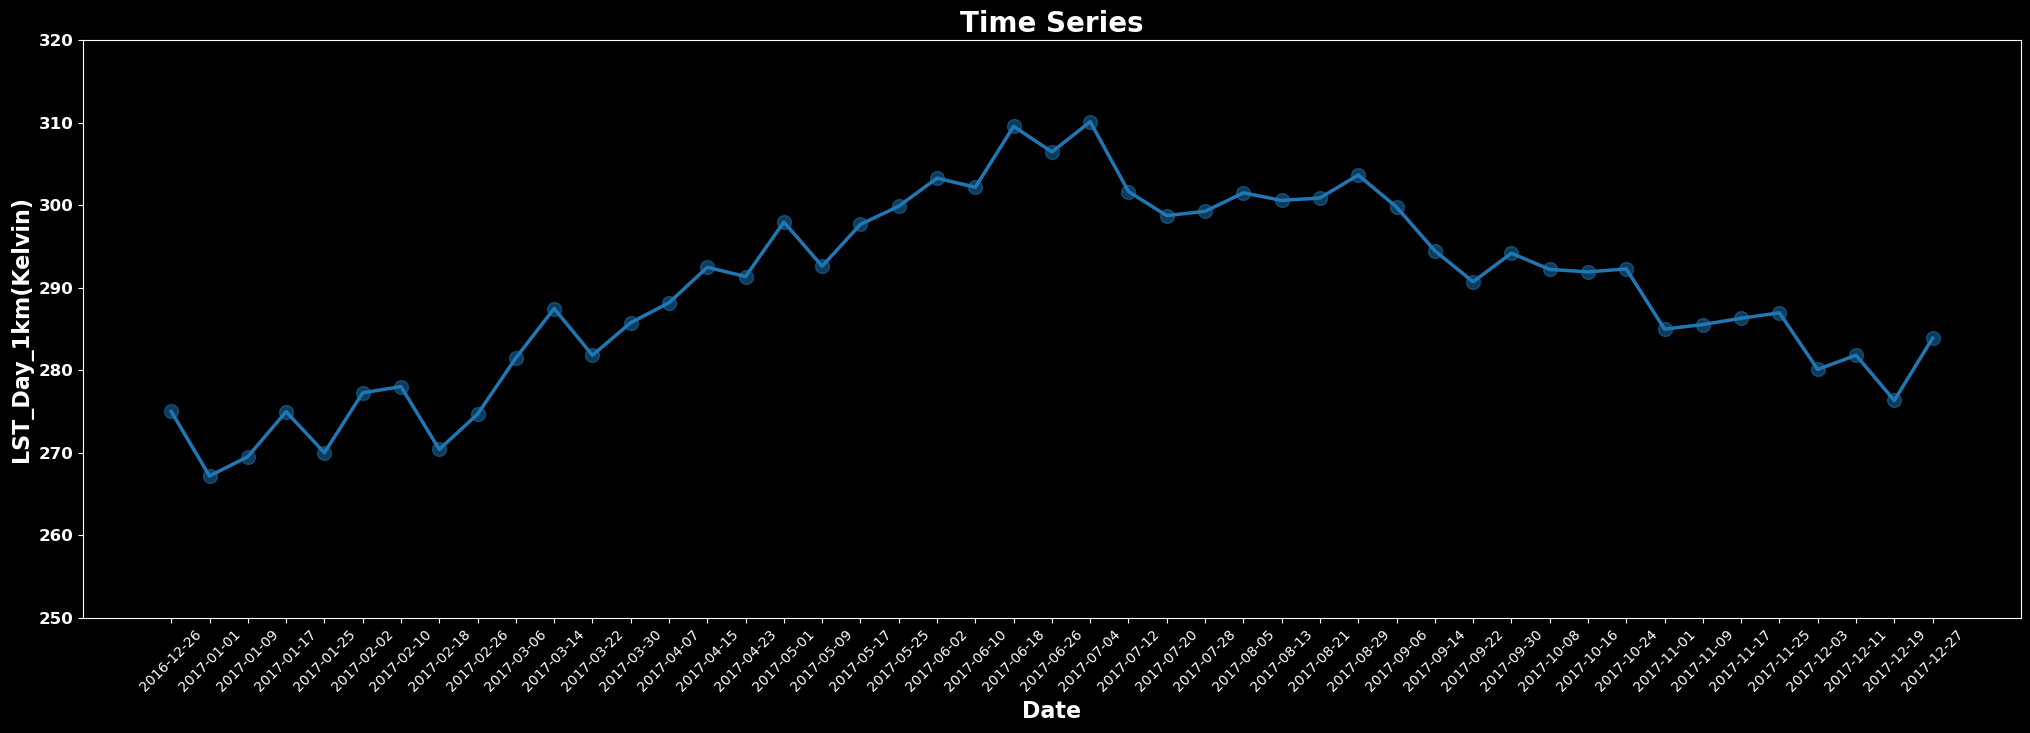

In [42]:
import warnings
warnings.filterwarnings("ignore")
plt.style.use("dark_background")                                                   # Set default background to black instead of white
fig = plt.figure(1, figsize=(25, 7.5))                                             # Set the figure size
ax = fig.add_subplot(111)                                                          # Create a subplot
ax.plot(lstDay_GC[lstDay_GC!=lstFill], 'k', lw=2.5, color='#1f77b4')               # Filter out fill values and plot as blue line
ax.plot(lstDay_GC[lstDay_GC!=lstFill], 'bo', ms=10, color='#1f77b4', alpha = 0.5)  # Filter out fill values and plot as blue circle
ax.set_xticks((np.arange(0,len(lstDay_GC))))                                       # Set the x ticks
ax.set_xticklabels(dates, rotation=45,fontsize=10)                                 # Set the x tick labels
ax.set_yticks((np.arange(250,325, 10)))                                            # Arrange the y ticks
ax.set_yticklabels(np.arange(250,325, 10),fontsize=12,fontweight='bold')           # Set the Y tick labels
ax.set_xlabel('Date',fontsize=16,fontweight='bold')                                # Set x-axis label
ax.set_ylabel("{}({})".format('LST_Day_1km', units),fontsize=16,fontweight='bold') # Set y-axis label
ax.set_title('Time Series',fontsize=20,fontweight='bold');                         # Set title

#### Next, add the LST Night values for Grand Canyon NP, and create a time series plot with both `LST_Day_1km` and `LST_Night_1km`.

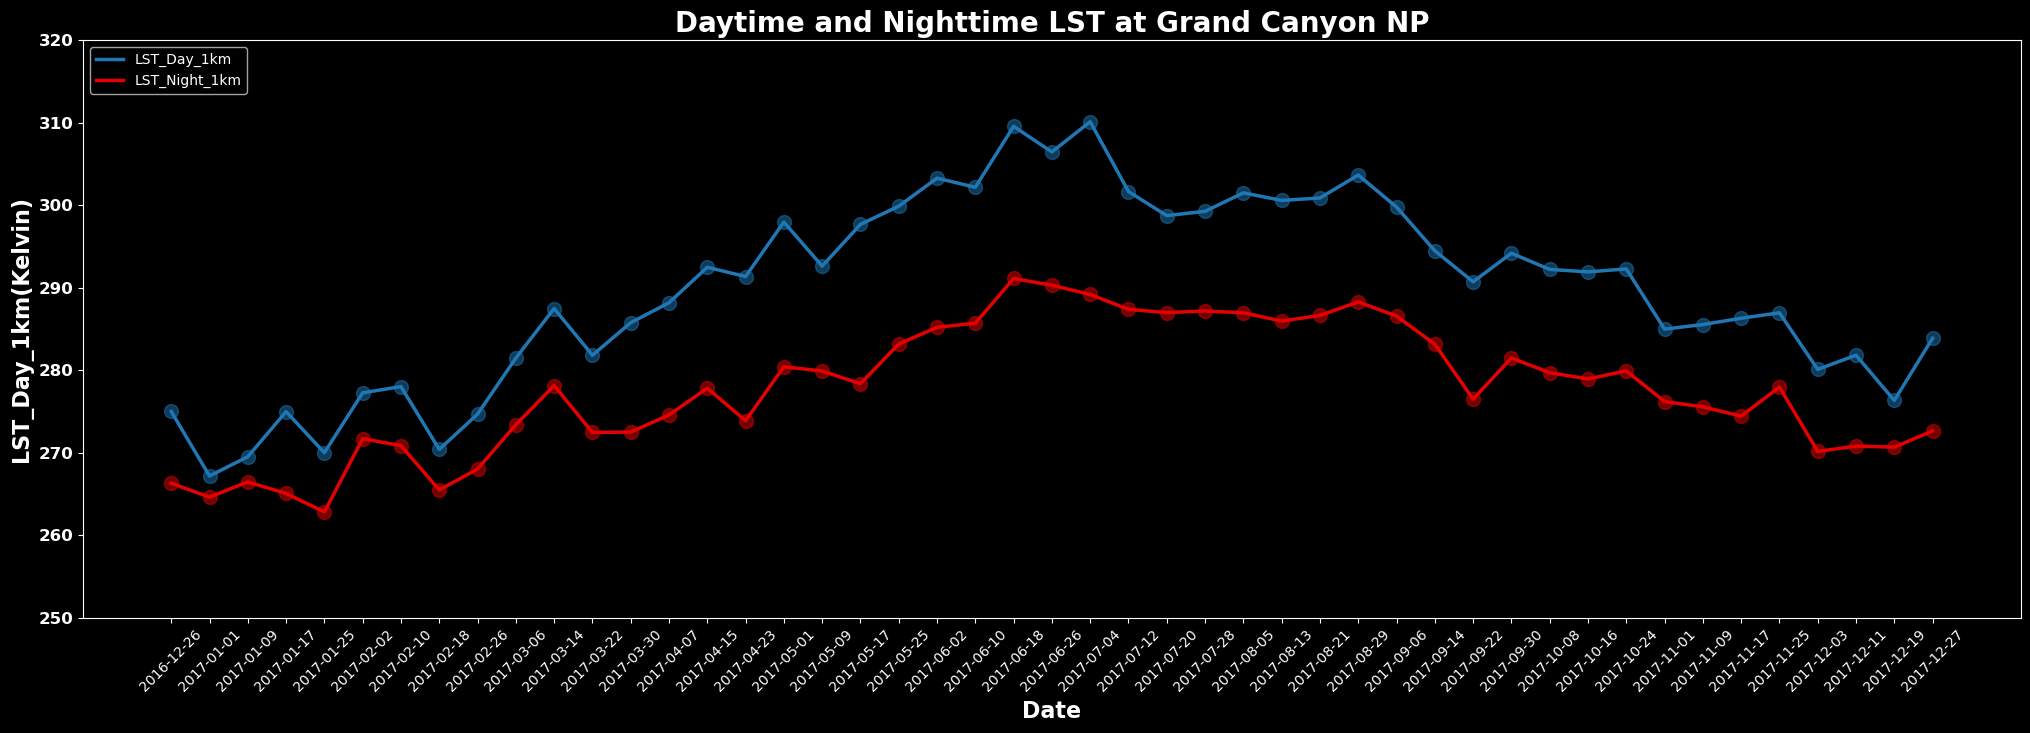

In [43]:
lstNight_GC = df['MOD11A2_061_LST_Night_1km'][df.Category == 'Grand Canyon']                # Filter df for pixel from GC, only keep LST Night
fig = plt.figure(1, figsize=(25, 7.5))                                                      # Set the figure size
plt.style.use("dark_background")                                                            # Set default background to black instead of white
ax = fig.add_subplot(111)                                                                   # Create a subplot
ax.plot(lstDay_GC[lstDay_GC!=lstFill], 'k', lw=2.5, color='#1f77b4')                        # Filter out fill values and plot as a blue line
ax.plot(lstNight_GC[lstNight_GC!=lstFill], 'k', lw=2.5, color='#e60000')                    # Filter out fill values and plot as a red line
ax.legend(('LST_Day_1km', 'LST_Night_1km'),loc='upper left')                                # Add a legend
ax.plot(lstDay_GC[lstDay_GC!=lstFill], 'bo', ms=10, color='#1f77b4', alpha = 0.5)           # Filter out fill values and plot as a blue circle
ax.plot(lstNight_GC[lstNight_GC!=lstFill], 'bo', ms=10, color='#e60000', alpha = 0.5)       # Filter out fill values and plot as a red circle
ax.set_xticks((np.arange(0,len(lstDay_GC))))                                                # Set the x ticks
ax.set_xticklabels(dates, rotation=45,fontsize=10)                                          # Set the x tick labels
ax.set_yticks((np.arange(250,325, 10)))                                                     # Arrange the y ticks
ax.set_yticklabels(np.arange(250,325, 10),fontsize=12,fontweight='bold')                    # Set the Y tick labels
ax.set_xlabel('Date',fontsize=16,fontweight='bold')                                         # Set x-axis label
ax.set_ylabel("{}({})".format('LST_Day_1km', units),fontsize=16,fontweight='bold')          # Set y-axis label
ax.set_title('Daytime and Nighttime LST at Grand Canyon NP',fontsize=20,fontweight='bold'); # Set title

#### Finally, bring in the daytime LST data from Zion National Park, and compare with daytime LST at Grand Canyon National Park, shown below in a scatterplot using `matplotlib`.

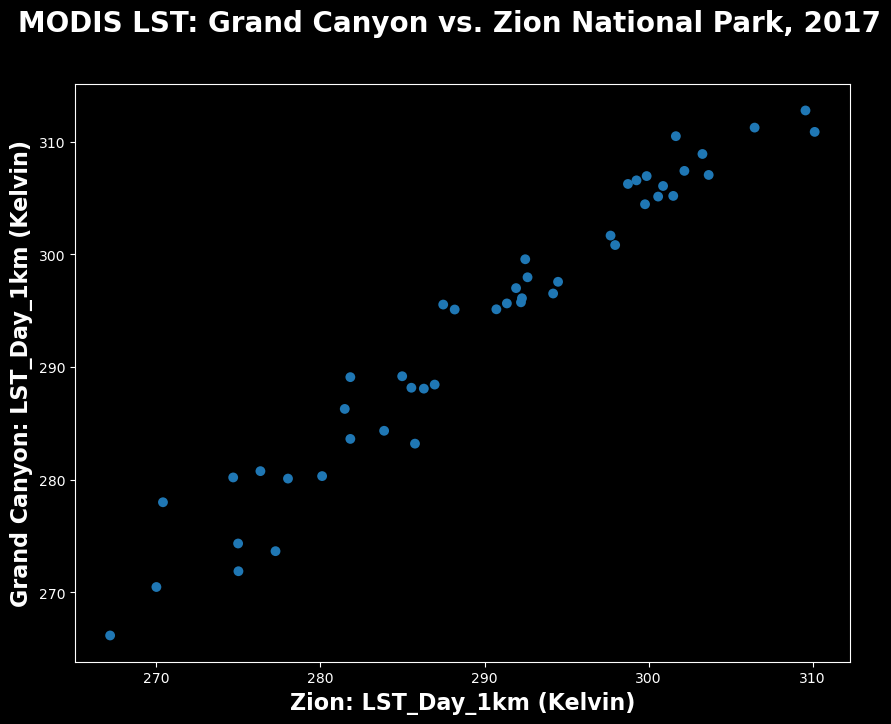

In [44]:
lstDay_Z = df['MOD11A2_061_LST_Day_1km'][df.Category == 'Zion']                                       # Filter for pixel from Zion, only keep LST Day
lstDay_Z[lstDay_Z==lstFill] = np.nan                                                                  # Set fill values = nan for plotting purposes
lstDay_GC[lstDay_GC==lstFill] = np.nan                                                                # Set fill values = nan for plotting purposes
fig = plt.figure(1, figsize=(10, 7.5))                                                                # Set the figure size                   
plt.style.use("dark_background")                                                                      # Set default background to black
fig.suptitle('MODIS LST: Grand Canyon vs. Zion National Park, 2017',fontsize=20,fontweight='bold')    # Add a title for the plot
ax = fig.add_subplot(111)                                                                             # Add subplot
ax.set_ylabel("{} {} ({})".format('Grand Canyon:','LST_Day_1km',units),fontsize=16,fontweight='bold') # Set y-axis label
ax.set_xlabel("{} {} ({})".format('Zion:','LST_Day_1km', units),fontsize=16,fontweight='bold')        # Set x-axis label
ax.scatter(lstDay_GC, lstDay_Z , alpha=1, c='#1f77b4', edgecolors='none', s=50, label="LST_Day");     # Plot values for both points

### This example can provide a template to use for your own research workflows. Leveraging the AρρEEARS API for searching, extracting, and formatting analysis ready data, and importing it directly into Python means that you can keep your entire research workflow in a single software program, from start to finish. 

***
<div class="alert alert-block alert-info">
<h1> Contact Information </h1> 
    
<h3> Material written by LP DAAC </h3>

<b>Contact:</b> LPDAAC@usgs.gov  

<b>Voice:</b> +1-605-594-6116  

<b>Organization:</b> Land Processes Distributed Active Archive Center (LP DAAC)  

<b>Website:</b> https://www.earthdata.nasa.gov/centers/lp-daac  

<b>Date last modified:</b> 06-12-2025  

LP DAAC Work performed under NASA contract NNG14HH33I. 